# Restaurant Tips: Which variables — payer’s gender, smoking status, day of the week, time of day, and party size — are associated with the tip percentage?

Group 2

Rafa Africa, Ben Ni, Yingming Sha, Michael Tham

STAT 301 Section 201

04/08/2025 

## (1) Introduction

Tipping is a widespread social norm in service industries, particularly in restaurants, where it can contribute significantly to employee income. However, tipping behavior is not entirely uniform. Numerous studies have found that factors such as customer demographics, situational context, and group dynamics can all influence how much people tip (Jewell, 2008). Understanding what drives tipping behavior is valuable not only for economic modeling, but also for helping restaurant managers and servers improve their service strategies and expectations.

This study explores whether variables such as payer’s gender, smoking status, day of the week, time of day, and party size are associated with the tip percentage left in a restaurant setting. Research has shown that, for instance, tipping tends to decrease as party size increases, likely due to a diffusion of responsibility or shared norms within larger groups (Haugom & Thrane, 2022). Similarly, differences in tipping patterns have been observed based on temporal variables like weekday vs. weekend or lunch vs. dinner (Jewell, 2008).

### Research Question
**Research Question**: Which variables, payer's gender, smoking status, day of the week, time of day, and dining party size, are associated with the tip percentage in a restaurant?

**Response variable** - tip percentage (total bill divided by the tip amount left by customer);

**Explanatory variables** - sex (gender), smoker (Yes or No), day (day of the week), time (Lunch or Dinner), and party size.

**Goal**: **Inference**, as it aims to understand the relationships between the sex, smoker, day, time, party size and the tip percentage. The goal is to identify which factors are significant in determining the tip percentage, rather than predicting individual tip percentage for future transactions.

## (2) Methods and Results

In [1]:
# First we load the library
library(tidyverse)
library(gridExtra) # for visualization
library(MASS) # for selection
library(car) # for vif
library(httr) # load data
library(rsample) # for train-test split
library(broom) # for tidying models

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




### a) Data 

#### Data Description 

The "Restaurant Tips Dataset" (Badole, 2024) details tipping behavior in a restaurant setting. The dataset was includes a variety of factors that may influence the amount a customer tips. Each entry represents a unique transaction, recording details such as the bill amount, tip given, gender of the payer, smoking preference, day of the week, time of day, and number of diners. This dataset contains 244 observations and 7 variables. The continuous variables are total_bill, tip, and size, while the categorical variables are sex, smoker, day, and time. 

The dataset used in this study was collected through observational means, meaning the data reflects real-world restaurant transactions without any experimental manipulation. As such, while we can investigate associations between variables and tip percentage, causal conclusions cannot be drawn.

**Description of each variable:**

| id | Key       | Description|
|----|-----------|-----------------------------------------------------------|
|1   |total_bill | Total bill amount in dollars                               |
|2   |tip        | Tip amount in dollars                                      |
|3   |sex        | Gender of the person paying the bill (Male/Female)         |
|4   |smoker     | Whether the person is a smoker (Yes/No)                    |
|5   |day        | Day of the transaction (Thur/Fri/Sat/Sun)                  |
|6   |time       | Time of day when the transaction took place (Lunch/Dinner) |
|7   |size       | Size of the dining party (number of people)                |

For this research question, total_bill and tip will be dropped (to avoid a multicollinearity issue) since the tip percentage is calculated based on these two covariates. 

In [2]:
# Main developer: Yingming, from Assignment 2
# Read the data into R
invisible(
GET(
  url = "https://www.kaggle.com/api/v1/datasets/download/saurabhbadole/restaurant-tips-dataset",
  authenticate("yingmingsha", "c52dacb47dd5f58ebfe40f4eb435b1b4", type = "basic"),
  write_disk("restaurant-tips-dataset.zip", overwrite = TRUE)
    )
)

unzip("restaurant-tips-dataset.zip")

tips <- read.csv("tips.csv")

head(tips)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


### b) Exploratory Data Analysis (EDA)

In [3]:
# Main developer: Yingming, from Assignment 2

# Check missing values and duplicated rows
summary_table <- tibble(
  Metric = c("Total Missing Values", "Total Duplicate Rows"),
  Count = c(sum(is.na(tips)), sum(duplicated(tips))) 
)
summary_table

Metric,Count
<chr>,<int>
Total Missing Values,0
Total Duplicate Rows,1


In [4]:
# Main developer: Yingming, from Assignment 2

# Clean and wrangle the data into a tidy format
tip_clean <- tips %>%
    distinct() %>% # remove duplicated row
    mutate(tip_per = tip / total_bill * 100) # calculate the bill percentage 

tip_final <- tip_clean %>%
    dplyr::select(-total_bill, -tip) # drop 'total_bill' and 'tip' columns (justification given above)

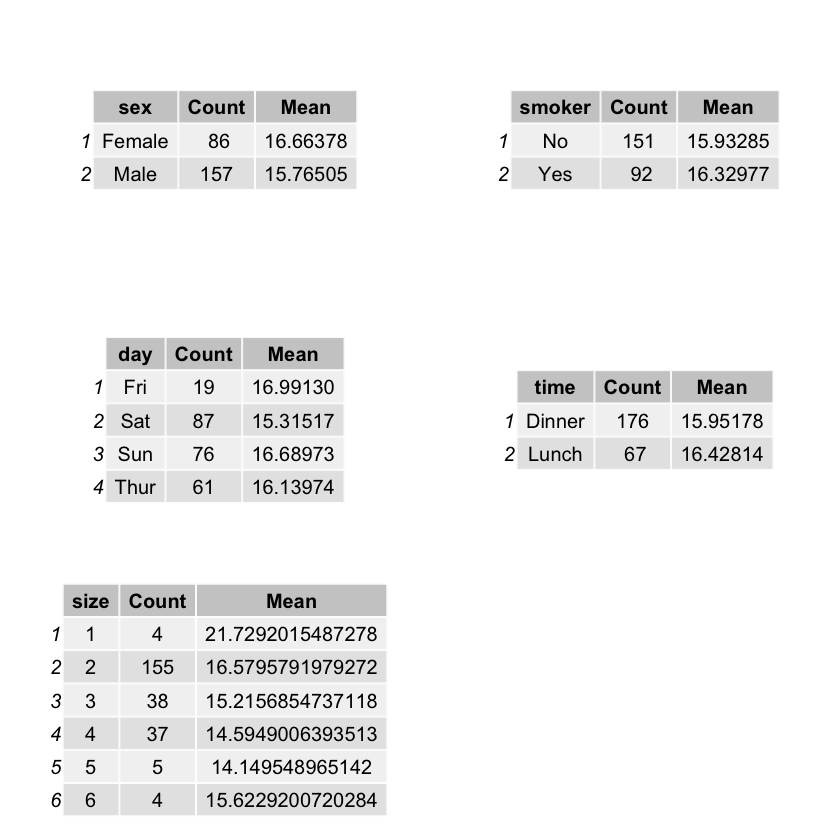

In [5]:
# Main developer: Yingming, from Assignment 2

# Summary tables that are relevant to the analysis
summary_table_sex <- tip_final %>%
  group_by(sex) %>%
  summarize(
      Count = n(),                         # Total count
      Mean = mean(tip_per, na.rm = TRUE)   # Mean
  )

summary_table_smo <- tip_final %>%
  group_by(smoker) %>%
  summarize(
    Count = n(),                                  
    Mean = mean(tip_per, na.rm = TRUE) 
  )

summary_table_day <- tip_final %>%
  group_by(day) %>%
  summarize(
    Count = n(),                               
    Mean = mean(tip_per, na.rm = TRUE)
  )

summary_table_time <- tip_final %>%
  group_by(time) %>%
  summarize(
    Count = n(),                                
    Mean = mean(tip_per, na.rm = TRUE)
  )

summary_table_size <- tip_final %>%
  group_by(size) %>%
  summarize(
      Count = n(),      
      Mean = mean(tip_per, na.rm = TRUE)   
  )

grid.arrange(
  tableGrob(summary_table_sex), tableGrob(summary_table_smo),
  tableGrob(summary_table_day), tableGrob(summary_table_time), tableGrob(summary_table_size),
  ncol = 2
)

Overall, the dataset has no missing values and one duplicated row. From the summary tables, we observe there is little difference in the average tip percentage across sex, smoker status, day, and time. But a potential decrease in the average tip percentage as the party size increases.

### Visualization plots

`geom_smooth()` using formula = 'y ~ x'


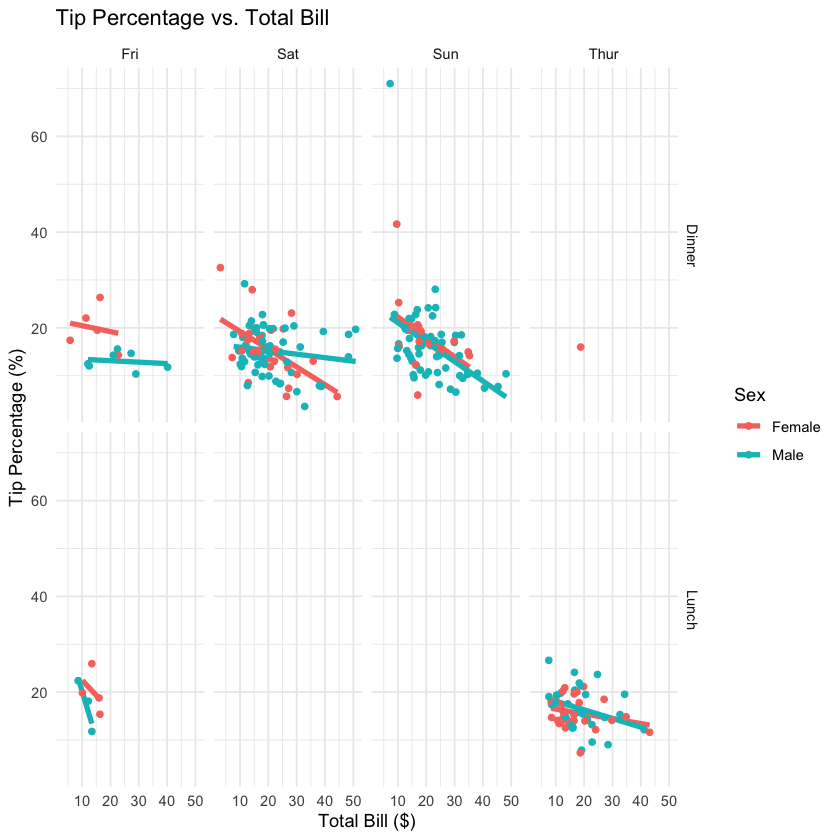

In [6]:
# Main developer: Rafa, from Assignment 2
# Scatterplot showing the tip percentages against the total bill
tips_plot <- tip_clean %>%
  ggplot(aes(x = total_bill, y = tip_per, color = sex)) +  
  geom_smooth(method = "lm", se = FALSE, linewidth = 1.5) +  
  geom_point() +
  facet_grid(time ~ day) +
  ggtitle("Tip Percentage vs. Total Bill") +
  xlab("Total Bill ($)") +
  ylab("Tip Percentage (%)") +
  labs(color = "Sex") +
  theme_minimal()

tips_plot

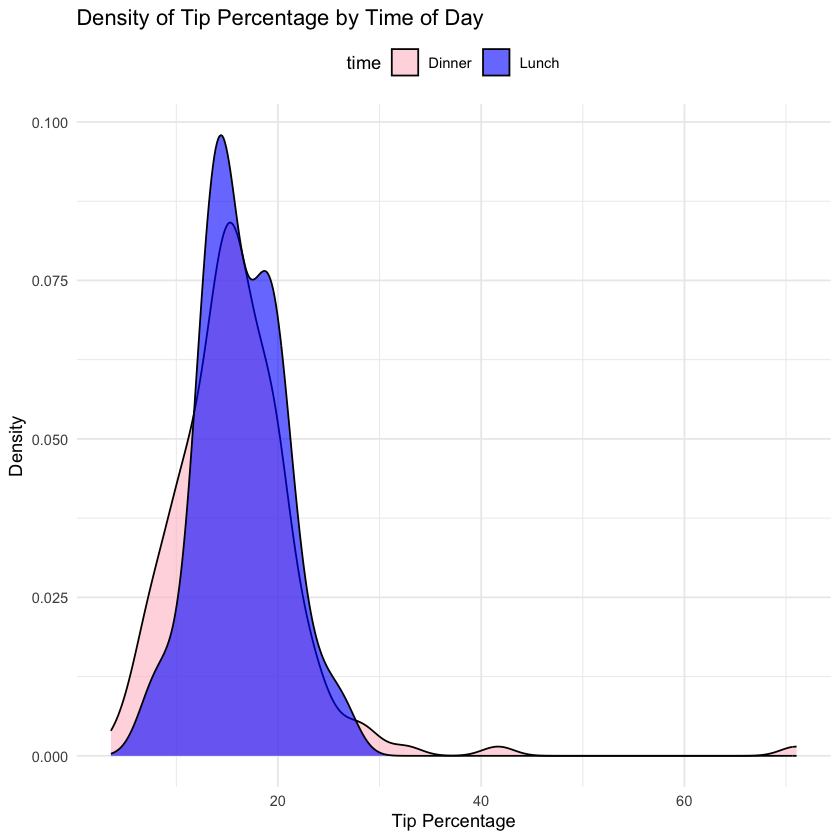

In [7]:
#Main Developer: Rafa
#Density plot to show what the most frequent tipping percentage based on the bill and seperated by time 
density_plot <- tip_final %>%
  ggplot(aes(x = tip_per, fill = time)) + 
  geom_density(alpha = 0.6) +  
  scale_fill_manual(values = c("pink", "blue")) +
  ggtitle("Density of Tip Percentage by Time of Day") +
  xlab("Tip Percentage") +
  ylab("Density") +
  theme_minimal() +
  theme(legend.position = "top")

density_plot

These visualizations are relevant as it gives us further insight into how the variables affect the tipping percentage. The scatterplot provides a general overview at exploring the different variables against the tip percentage and total bill. This gives us insight into what days are the most popular, what time has the most customers, and whether sex plays a role in the tip percentage. Observing the other factors also shows us where the data may be incomplete such as Thursday dinner only having one observation or Saturday and Sunday lunches having none. These insights help us to understand the data and create better interpretations by being cautious when generalizaing the findings presented in the data and the analysis.

The density plot is a more focused and clear visualization to better understand tipping percentage. Here it narrows the tipping percentage into two different density plots separated by time. This is easier to interpret and it shows what amount results in the highest percentage. This plot shows its findings of being that there is a higher likelihood that there would be a larger tip percent during lunch time with it being slightly above 8% and the largest for dinner being below 7.5% with the average total bill for this being between $10-20.

### c) Methods: Plan

After our group interview, we decided that 2 of us would try Poisson regression and 2 of us would try Multiple Linear Regression and then compare the results to ultimately decide a final model for the final group project.

**Proposed Method:** Multiple Linear Regression & Poisson Regression Model

**Why is MLR appropriate?**

This method is suitable because it allows us to model the relationship between a continuous response variable (tip percentage) and multiple predictor variables. The coefficients of the regression model will give us clear insights into how each predictor influences the tip percentage and this makes it easy to interpret.

**Why is Poisson Regression Appropriate?**

- Tip percentage is a rate-like variable: Poisson regression models count-based data, but it is also commonly used for rate data, like percentages. Since tip percentage is a proportion of the total bill, it behaves similarly to a rate.
- Handles non-negative dependent variables: Tip percentage is always ≥ 0, making Poisson regression a good fit since it prevents predicting negative values.
- Log-link function ensures a multiplicative effect: Instead of assuming a linear relationship (like in multiple linear regression), Poisson regression assumes that predictor variables have a multiplicative effect on the expected outcome (tip percentage). This makes it more flexible in modeling tipping behavior.

**Which assumptions are required, if any, apply to MLR and Poisson Regression?**
1. Linearity: The relationship between the predictors and the response variable is assumed to be linear. 
2. Independence: Observations are assumed to be independent of each other, meaning that the tip percentage of one transaction doesn’t affect others.
3. Homoscedasticity: The variance of the residuals (errors) is assumed to be constant across all levels of the predictors.
4. Normality of Residuals: The residuals are assumed to follow a normal distribution.
5. Non-negative Response Variable: The outcome variable (tip_percentage) must be ≥ 0.

**What are the potential limitations or weaknesses of MLR?**
1. Linearity Assumption: The model may not perform well if the relationship is non-linear. 
2. Multicollinearity: If any of the predictors are highly correlated with each other, it could lead to multicollinearity, where it becomes difficult to isolate the effect of individual predictors. 

**What are the potential limitations or weaknesses of Poisson Regression?**
1. Overdispersion: If the variance of the data is significantly greater than the mean, Poisson regression may not be the best fit.
2. Assumes a Log-Linear Relationship: If the relationship between tip percentage and predictors is not exponential, Poisson regression may not model it well.
3. Interpretation Can Be Less Intuitive: Unlike linear regression, where coefficients represent direct changes, Poisson regression coefficients represent multiplicative effects (i.e., changes in the log scale), which may require additional steps to interpret.

**Variable Selection Method (for MLR):** Stepwise Selection

We will be using stepwise selection (with AIC) to refine our model and identify the most significant predictors of tip percentage. Stepwise selection is useful when there is some uncertainty about which predictors are most relevant, as it allows for both adding and removing variables based on statistical criteria. 

**Variable Selection Method (for Poisson):** n/a

Regarding using LASSO and other advanced regularization techniques, we went against using these as they are primarily used in predictive modeling to perform variable selection when there are many predictors. In this analysis, the focus is on inference, not to build a model that predicts tipping behavior. Additionally, the dataset includes only a small number of covariates, making regularization unnecessary.

### Computational Code (MLR)

In [8]:
# Main developer: Yingming, from Assignment 2

tip_full_model <- lm(tip_per ~ ., data = tip_final)

# Check multicollinearity in the full Model
vif(tip_full_model)

,GVIF,Df,GVIF^(1/(2*Df))
sex,1.057406,1,1.028303
smoker,1.133435,1,1.064629
day,10.460180,3,1.478847
time,8.997935,1,2.999656
size,1.061287,1,1.030188


In [9]:
# Main developer: Michael
# Summary of results
suppressWarnings({
tips_mlr_model_results <-
    tidy(tip_full_model, conf.int = TRUE) %>%
    mutate_if(is.numeric, round, 4)
})

tips_mlr_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),18.3120,2.0791,8.8077,0.0000,14.2160,22.4080
sexMale,-0.8724,0.8383,-1.0406,0.2991,-2.5240,0.7792
smokerYes,0.3911,0.8557,0.4570,0.6481,-1.2947,2.0768
daySat,-0.1646,1.8381,-0.0896,0.9287,-3.7858,3.4565
daySun,1.6886,1.9071,0.8854,0.3768,-2.0687,5.4459
dayThur,-1.7726,2.3282,-0.7614,0.4472,-6.3594,2.8142
timeLunch,2.3383,2.6168,0.8936,0.3725,-2.8171,7.4938
size,-0.9651,0.4226,-2.2838,0.0233,-1.7976,-0.1326


**Initial Analysis:**

From vif(), `day` and `time` may exhibit multicollinearity, with `day` being more serious (GVIF > 10). 

From the summary(), we observe the following:

- sexMale: Coefficient = -0.87 (p = 0.299), suggesting that men tip 0.87% less than women. However, this result is not statistically significant.
- smokerYes: Coefficient = 0.39 (p = 0.648), indicating that smokers tip 0.39% more than non-smokers. But this effect is also not statistically significant.
- day (reference: Friday): There are no statistically significant differences in tipping between days (Saturday, Sunday, Thursday), based on the p-values.
- timeLunch: Coefficient = 2.34 (p = 0.373), suggesting that lunch customers tip 2.34% more than dinner customers, but this effect is not significant.
- size: Coefficient = -0.97 (p = 0.023), meaning larger parties tip 0.97% less. This result is statistically significant.

Fitting the full model provides some insight into how the predictor variables relate to the response variable. However, to improve the model, we will now apply a variable selection method to identify a more optimal model.

In [10]:
# Main developer: Yingming

# Split data into training and testing sets
set.seed(123)  
tip_split <- initial_split(tip_final, prop = 0.7, strata = tip_per)  # 70% train, 30% test
tip_train <- training(tip_split)
tip_test <- testing(tip_split)

# Fit model using training data
# Full model with all covariates
tip_full_train <- lm(tip_per ~ ., data = tip_train)

# Perform stepwise selection
tip_backward <- stepAIC(tip_full_train, direction = "backward", k = 2)

Start:  AIC=637.9
tip_per ~ sex + smoker + day + time + size

         Df Sum of Sq    RSS    AIC
- time    1     2.101 6809.3 635.95
- smoker  1    25.849 6833.0 636.53
- sex     1    65.323 6872.5 637.50
- day     3   236.615 7043.8 637.64
- size    1    71.806 6879.0 637.66
<none>                6807.2 637.90

Step:  AIC=635.95
tip_per ~ sex + smoker + day + size

         Df Sum of Sq    RSS    AIC
- smoker  1    27.432 6836.7 634.62
- sex     1    64.136 6873.4 635.52
- size    1    72.763 6882.1 635.73
<none>                6809.3 635.95
- day     3   254.529 7063.8 636.11

Step:  AIC=634.62
tip_per ~ sex + day + size

       Df Sum of Sq    RSS    AIC
- sex   1    62.008 6898.7 634.14
- day   3   240.339 7077.1 634.43
<none>              6836.7 634.62
- size  1    86.866 6923.6 634.75

Step:  AIC=634.14
tip_per ~ day + size

       Df Sum of Sq    RSS    AIC
- day   3    221.94 7120.7 633.46
<none>              6898.7 634.14
- size  1    100.49 6999.2 634.57

Step:  AIC=633.46
t

Using stepwise selection, it was found that party size (`size`) is the most important factor influencing tip percentage, while other variables do not contribute meaningfully. This finding aligns with our previous interpretation of the full model.

In [11]:
# Main developer: Yingming, from Assignment 2

# Fit the model using the selected variables
tip_select <- lm(tip_per ~ size, data = tip_train)

# Compare the selected model and the full model using ANOVA
anova(tip_select, tip_full_train)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,166,7120.663,NA,NA,NA,NA
2,160,6807.187,6,313.4763,1.228021,0.2946122


According to the ANOVA results, there is no significant difference between the full model and the simplified model. The p-value of 0.29 (greater than 0.05) indicates that the full model with the additional predictors does not fit significantly better than the simplified model. Therefore, the reduced model might be sufficient.

In [12]:
# Main developer: Yingming

pred_select <- predict(tip_select, newdata = tip_test)
rmse_select <- sqrt(mean((tip_test$tip_per - pred_select)^2))

# Calculate RMSE for the full model
pred_full <- predict(tip_full_train, newdata = tip_test) 
rmse_full <- sqrt(mean((tip_test$tip_per - pred_full)^2))

# Calculate R^2 values
total <- sum((tip_test$tip_per - mean(tip_test$tip_per))^2)
residual_select <- sum((tip_test$tip_per - pred_select)^2)
r2_select <- 1 - (residual_select / total)

residual_full <- sum((tip_test$tip_per - pred_full)^2)
r2_full <- 1 - (residual_full / total)

# Create a data frame to store results
results <- data.frame(
  Model = c("Selected Model", "Full Model"),
  RMSE = c(rmse_select, rmse_full),
  R_2 = c(r2_select, r2_full)
)

# Print the table
print(results)

           Model     RMSE         R_2
1 Selected Model 4.854025  0.06002078
2     Full Model 5.143111 -0.05527592


The selected model has a lower RMSE (4.854) compared to the full model (5.143), indicating better prediction accuracy. The selected model also has a positive R² (0.060), meaning it explains 6% of the variation in the response, while the full model has a negative R² (-0.055), suggesting poor performance. Therefore, the selected model is the better choice.

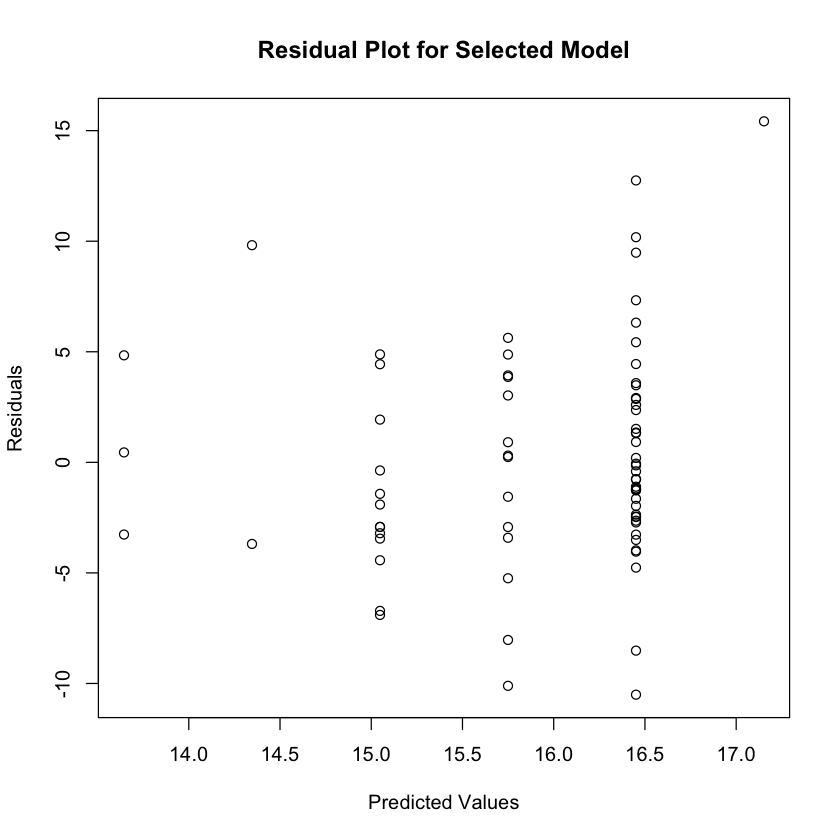

In [13]:
# Main developer: Yingming
# Residual plot
# Calculate residuals for the selected model
residual_select <- tip_test$tip_per - pred_select

# Calculate residuals for the full model
residual_full <- tip_test$tip_per - pred_full

# Residual Plot for Selected Model
plot(pred_select, residual_select, 
     xlab = "Predicted Values", 
     ylab = "Residuals",
     main = "Residual Plot for Selected Model")

Figure 1. Residual Plot for Selected Model

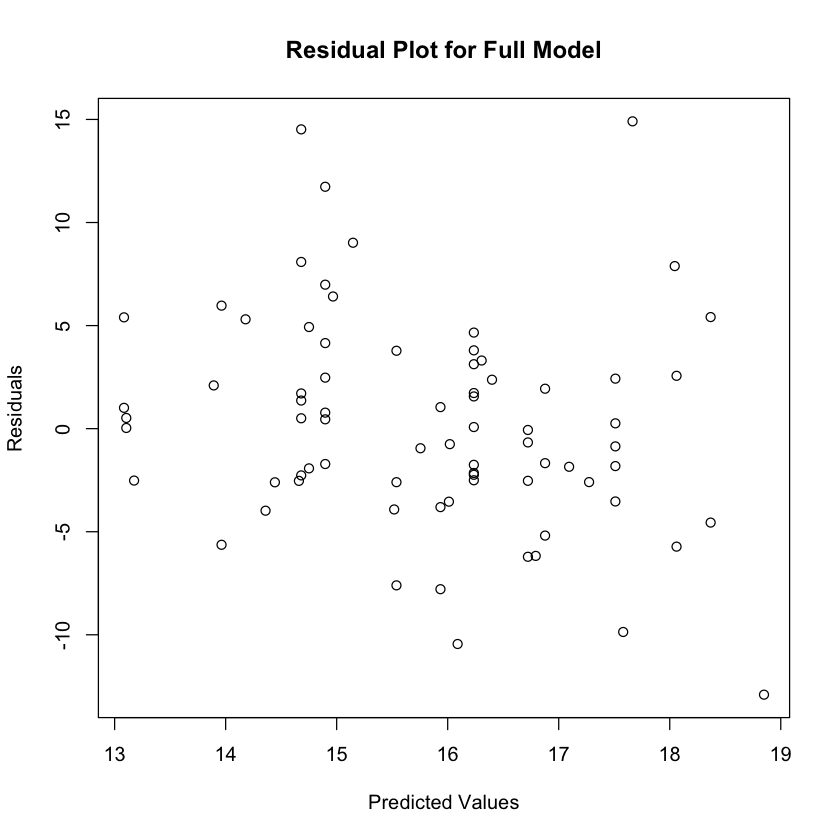

In [14]:
# Main developer: Yingming
# Residual Plot for Full Model
plot(pred_full, residual_full, 
     xlab = "Predicted Values", 
     ylab = "Residuals",
     main = "Residual Plot for Full Model")

Figure 2. Residual Plot for Full Model

**Interpretation of the plots**:

The full model's residuals appear more random and evenly distributed, which is a key assumption in linear regression (residuals should be randomly scattered with constant variance and mean near zero). The selected model violates this by showing strong clustering and signs of heteroscedasticity. The results for the RMSE and R² suggest the selected model is better for prediction accuracy while the full model might be more appropriate in terms of following the key assumptions with linear regression.

Despite the selected model having slightly better prediction performance as seen in the lower RMSE and higher $R^2$, the violation of the key assumptions (heteroscedasticity) make it less preferable. Ultimately, this is a decision between prediction accuracy vs interpretability but considering this is a key assumption in linear regression and the performance differences are small, the full model is preferable for more reliable and intrepretable results.

### Computational Code (Poisson Regression)

In [15]:
# Main developer: Rafa and Michael
# Poisson Model Training
# Use the existing training
# Used family = quasipoisson to check for overdispersion
suppressWarnings({
glm_model_tip_train <- glm(tip_per ~ ., 
                           data = tip_train, 
                           family = quasipoisson)
})

summary(glm_model_tip_train)


Call:
glm(formula = tip_per ~ ., family = quasipoisson, data = tip_train)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.90371    0.15140  19.179   <2e-16 ***
sexMale     -0.08330    0.06390  -1.303    0.194    
smokerYes    0.05307    0.06560   0.809    0.420    
daySat      -0.03087    0.12590  -0.245    0.807    
daySun       0.14376    0.12951   1.110    0.269    
dayThur     -0.05807    0.17262  -0.336    0.737    
timeLunch    0.04071    0.18389   0.221    0.825    
size        -0.05097    0.03737  -1.364    0.175    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 2.45448)

    Null deviance: 363.77  on 167  degrees of freedom
Residual deviance: 340.40  on 160  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


In [16]:
# Main developer: Michael, from Assignment 2
# Summary of the Poisson model
suppressWarnings({
tips_poisson_model_results <- 
   tidy(glm_model_tip_train, conf.int = TRUE) %>%
   mutate_if(is.numeric, round, 4)
})

tips_poisson_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.9037,0.1514,19.1789,0.0000,2.6023,3.1963
sexMale,-0.0833,0.0639,-1.3035,0.1943,-0.2079,0.0427
smokerYes,0.0531,0.0656,0.8089,0.4197,-0.0761,0.1812
daySat,-0.0309,0.1259,-0.2452,0.8066,-0.2717,0.2225
daySun,0.1438,0.1295,1.1101,0.2686,-0.1045,0.4038
dayThur,-0.0581,0.1726,-0.3364,0.7370,-0.3890,0.2879
timeLunch,0.0407,0.1839,0.2214,0.8251,-0.3216,0.3996
size,-0.0510,0.0374,-1.3638,0.1745,-0.1252,0.0213


In [17]:
# Main developer: Rafa

# Check for multicollinearity in the Poisson model
vif(glm_model_tip_train)

,GVIF,Df,GVIF^(1/(2*Df))
sex,1.032495,1,1.016118
smoker,1.148163,1,1.071524
day,7.578580,3,1.401516
time,6.520353,1,2.553498
size,1.090100,1,1.044079


In [18]:
# Main developer: Rafa
# Predictions using the trained Poisson model on the testing set
predictions <- predict(glm_model_tip_train, 
                       newdata = tip_test, 
                       type = "response")

# Residual deviance on the testing set
residual_deviance <- deviance(glm_model_tip_train)

# Null deviance for comparison (intercept-only model)
null_deviance <- deviance(glm_model_tip_train, type = "null")

In [19]:
# Main developer: Rafa
# Deviance ratio (lower is better)
deviance_ratio <- residual_deviance / null_deviance
deviance_ratio

[1] 1

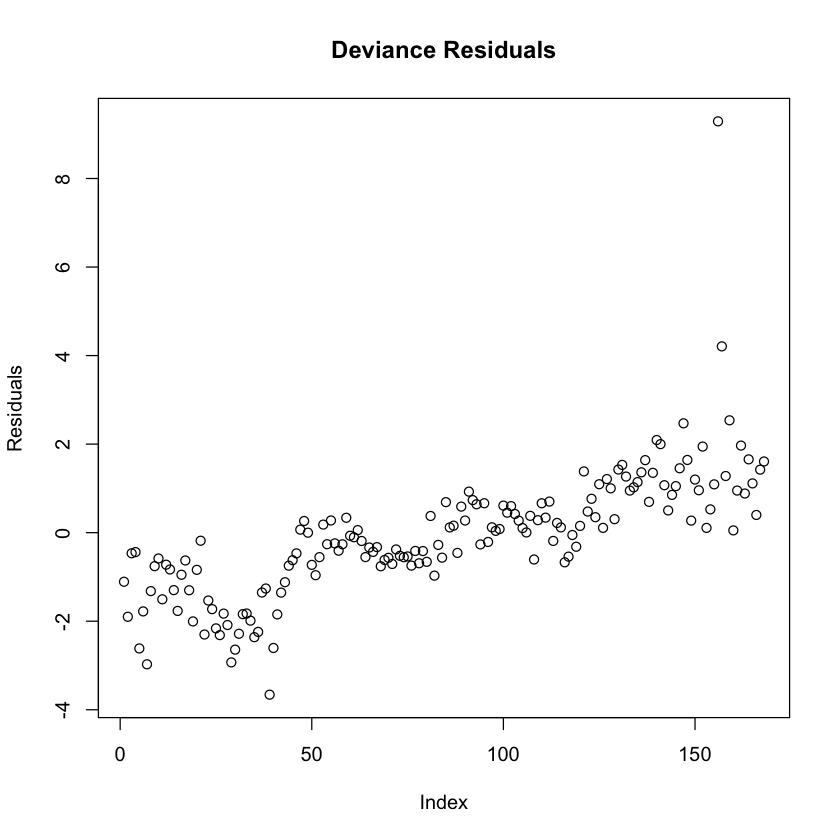

In [20]:
# Main developer: Rafa
# Deviance residuals
deviance_residuals <- residuals(glm_model_tip_train, type = "deviance")
plot(deviance_residuals, main = "Deviance Residuals", ylab = "Residuals", xlab = "Index")

Figure 3. Residual Plot for Poisson Model

This model appears to violate key assumptions of Poisson regression, such as overdispersion (with a statistic of 2.45), a deviance ratio of 1, and patterned residuals. The use of several predictors fails to improve the model’s fit. This suggests that the model, in its current form, is not reliable for inference and would benefit from refinement or the use of a different modeling approach.

### (3) Discussion
### Summarize what you found and the implications/impact of your findings

Our MLR results showed that only party size was statistically significant (p = 0.0233), with a negative association: as party size increases, tip percentage tends to decrease slightly. This was reinforced by stepwise variable selection, which retained only size as a predictor. Other variables, including gender, smoker status, day, and time, were not significantly associated with tipping.

Although the reduced model had slightly better predictive performance (lower RMSE and higher R²), it violated key linear regression assumptions, particularly heteroscedasticity in the residuals. The full model had more stable residual behavior and satisfied assumptions more closely, making it the better choice for inference. In contrast, the Poisson regression model showed no significant predictors and suffered from overdispersion (deviance ratio ≈ 2.45), violating key model assumptions. Given its better interpretability and alignment with assumptions, we selected MLR as the preferred model.

To answer our research question: party size is the only variable significantly associated with tip percentage. In a practical sense, this finding could inform restaurant policy, such as implementing mandatory gratuities for larger parties to ensure consistent tipping.


### If relevant, discuss whether your results were what you expected to find

Our results did not exactly match our expectations. We were shocked to see that party size would negatively impact tipping. Furthermore, we also expected to find significant associations for other variables, particularly payer’s gender and time of day. Their lack of significance in our model was surprising and suggests a few possible explanations:
- The effects of gender or time of day may be context-dependent, and not generalizable across all restaurant types or locations.
- The sample size and scope of the dataset may have limited our ability to detect smaller effects.
- These variables may interact with other unmeasured factors (e.g., service quality, payment method) that were not available in this dataset.


### Discuss how your model could be improved

Our model explains only 6% of the variance in tip percentage, indicating room for improvement. As we are focused on inference, enhancements should prioritize model interpretability and assumption validity. Future improvements could include adding interaction terms (e.g., size × time), using robust standard errors or weighted least squares to address heteroscedasticity, and examining influential observations that may distort results. These steps can strengthen model reliability even without introducing new variables. Additionally, assessing and possibly removing influential or outlier observations could result in a more stable and interpretable model.

### Discuss future questions/research this study could lead to

This study points to multiple directions for future research. A key limitation is the absence of variables like service quality, customer income, or restaurant type, which may be strong determinants of tipping behavior. Future work could incorporate longitudinal or transactional data to examine temporal tipping patterns, or expand across regions to explore cultural variations. If experimental data were available, researchers could move toward causal inference, testing whether interventions such as suggested tipping amounts or service prompts impact customer behavior.

### (4) References

Badole, S. (2021). Restaurant Tips Dataset. Kaggle. https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset/data

Haugom, E., & Thrane, C. (2022). The Effects of Party Size and Dining Time on Restaurant Patrons’ Tipping Behavior: Results from a Large-Scale Transaction Database. Retrieved from https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID4101280_code5225184.pdf?abstractid=4101280&mirid=1

Jewell, C. N. (2008). Factors Influencing Tipping Behavior in a Restaurant. Psi Chi Journal of Undergraduate Research, 13(1), 38–48. Retrieved from https://cdn.ymaws.com/www.psichi.org/resource/resmgr/journal_2008/Spring08JNJewell.pdf